In [1]:
from numpy import random
from IPython.display import clear_output
import time
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from JSAnimation.IPython_display import display_animation, anim_to_html
from matplotlib import animation
from statsmodels.stats.stattools import durbin_watson
from scipy import ndimage

In [2]:
def life_step(X):
    
    """Game of life step using generator expressions"""
    
    nbrs_count = sum(np.roll(np.roll(X, i, 0), j, 1)
                     for i in (-1, 0, 1) for j in (-1, 0, 1)
                     if (i != 0 or j != 0))
    
    return (nbrs_count == 3) | (X & (nbrs_count == 2))

In [3]:
def life_animation(X, dpi=80, frames=10, interval=300, mode='loop'):
    
    X = np.asarray(X)
    assert X.ndim == 2
    X = X.astype(int) 
    X_blank = np.zeros_like(X)
    figsize = (X.shape[1] * 10. / dpi, X.shape[0] * 10. / dpi)  
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1], xticks=[], yticks=[], frameon=False)
    im = ax.imshow(X, cmap='hot', interpolation='nearest')
    im.set_clim(-0.05, 10)
    
    # initialization function: plot the background of each frame
    
    def init():
        
        im.set_data(X_blank)
        return (im,)
    
    # animation function.  This is called sequentially
    
    def animate(i):
        
        im.set_data(animate.X)
        animate.X = life_step(animate.X)
        
        return (im,)
    
    animate.X = X
    anim = animation.FuncAnimation(fig,
                                   animate,
                                   init_func=init,
                                   frames=frames,
                                   interval=interval)
    
    return display_animation(anim, default_mode=mode)      

In [4]:
def add_border(x, border = 3):
        
        offset = int((border - 1)/2)
        
        background = np.repeat(0, x.shape[0] *
                               x.shape[1] *
                               border *
                               border).reshape([x.shape[0] *
                                                border, x.shape[1] *
                                                border])
        background[x.shape[0] *
                   offset:-x.shape[0] *
                   offset, x.shape[1] *
                   offset:-x.shape[1] *
                   offset] = x
        
        return(background)

In [5]:
def sig_func(x,y):
    return(1/(1+np.exp(-(np.dot(x,y)))))

[86  7 67 14 13 18 33 49  9 39 32 44  0 52 57 34 48 22 77 80 59 70 53 69
 37 35  1 26 58 74 15 20 94 97 11 79 72 50 47 40 78 62 19 64 75 42 82 60
 45 76 12 71  6 89  4 87 73 54 85 17 31 24 41 96 43 28 16 88  2 99  5 66
 95 63 27  8 98 36 92 21 55 65 91 81 56 61 68 38 29 83 90 25 23 46  3 10
 51 30 84 93]
[6.16685234 6.08591249 6.07382898 6.05193863 6.04664384 6.02305506
 6.015321   5.98928908 5.92459476 5.90179376 5.89756243 5.88494014
 5.88494014 5.88493543 5.88433355 5.84662418 5.76803033 5.72940033
 5.62941892 5.55658059 5.51490486 5.50590022 5.50293492 5.4953532
 5.48491075 5.47390333 5.46591703 5.46108984 5.45911259 5.45359942
 5.45352611 5.45269379 5.44386721 5.43911935 5.42570998 5.42240087
 5.41892471 5.41555033 5.41020247 5.40649563 5.40613504 5.40599291
 5.39128203 5.38962042 5.38683059 5.38344231 5.3750776  5.36452022
 5.36142623 5.34495937 5.33330717 5.31111275 5.30020217 5.25076518
 5.2396957  5.23694219 5.18505821 5.18417412 5.14945615 5.08153252
 4.91692728 4.91405705 4.


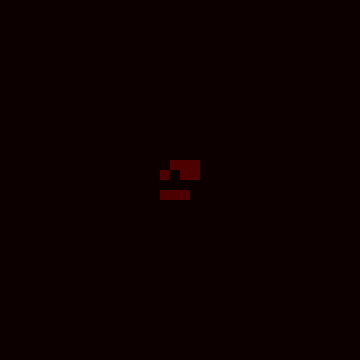
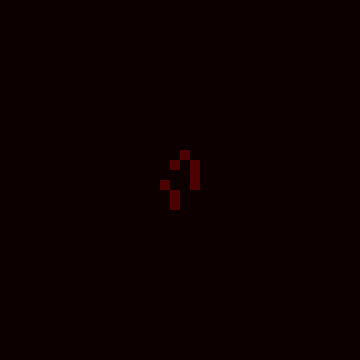
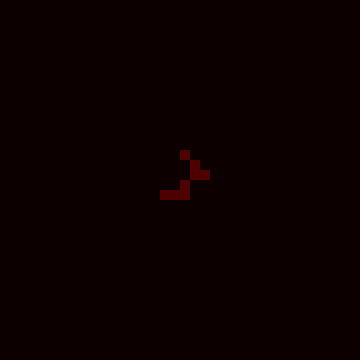
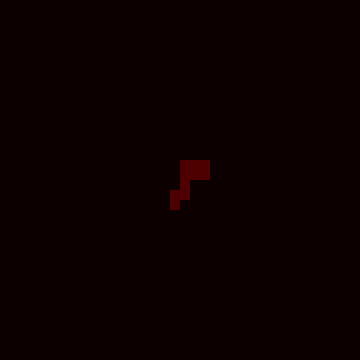
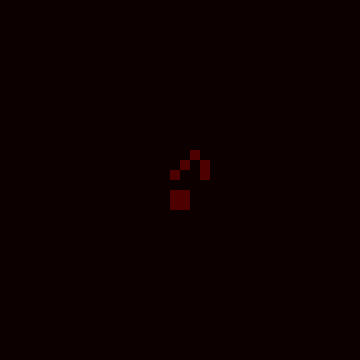
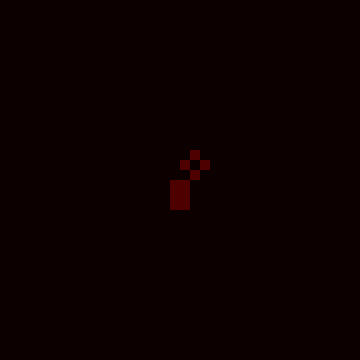
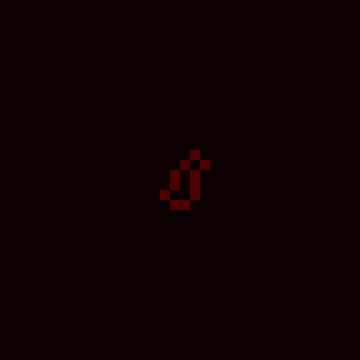
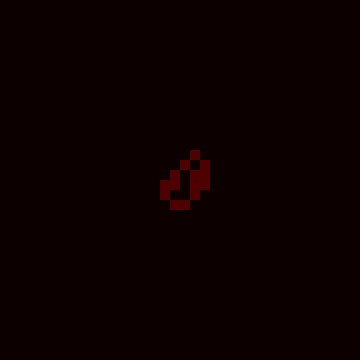
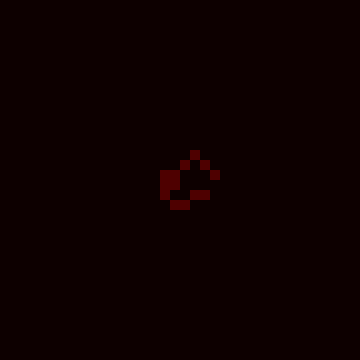
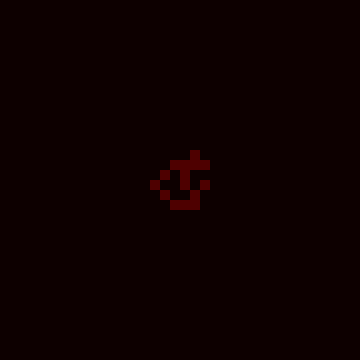
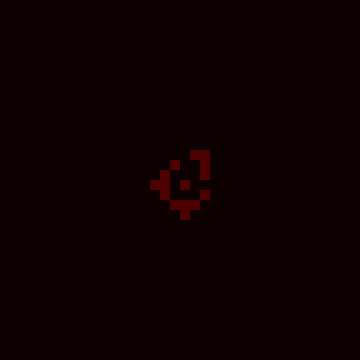
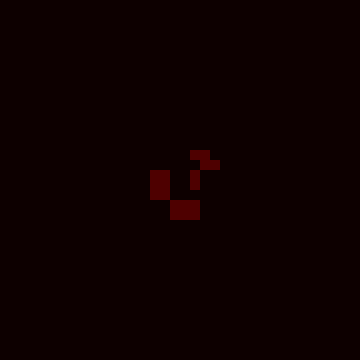
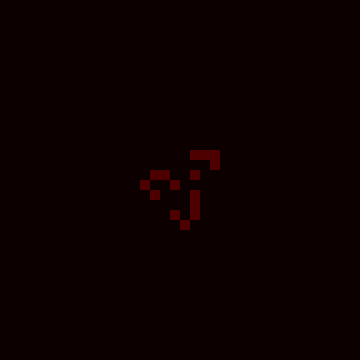
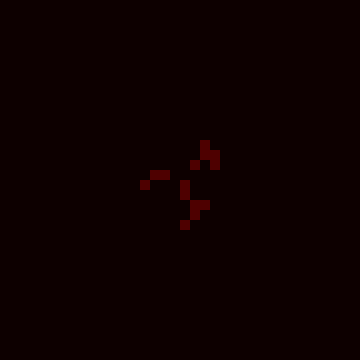
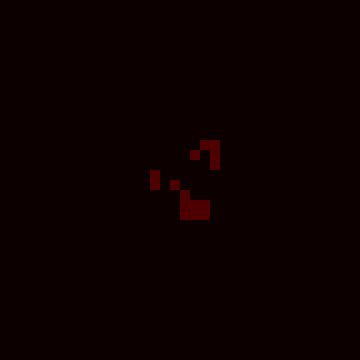
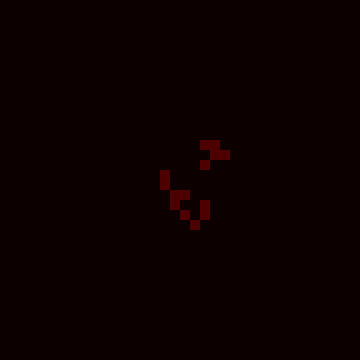
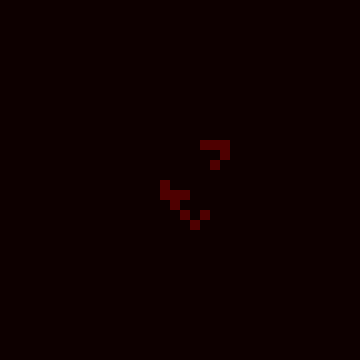
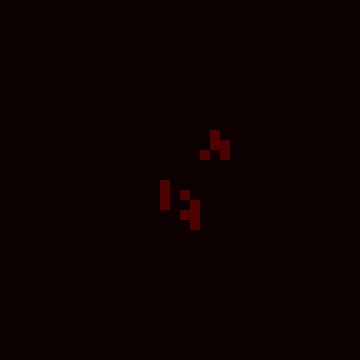
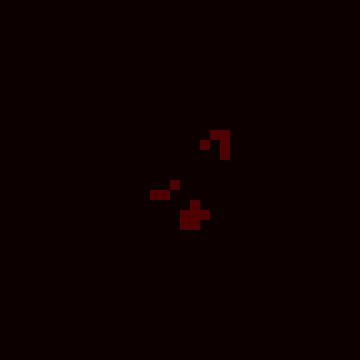
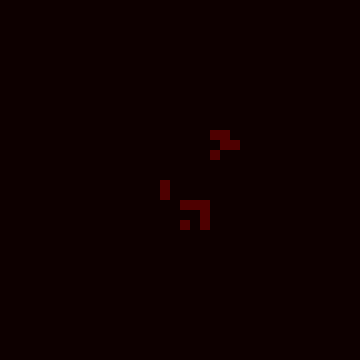
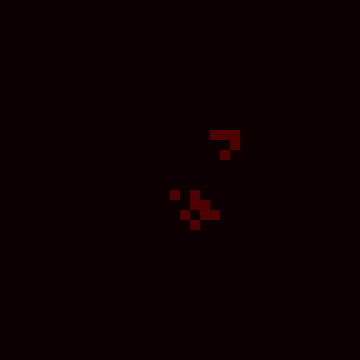
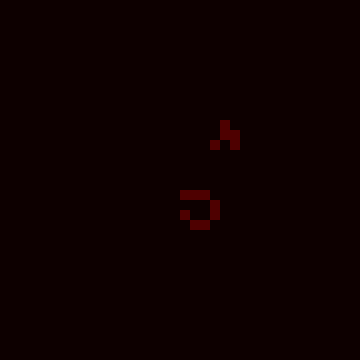
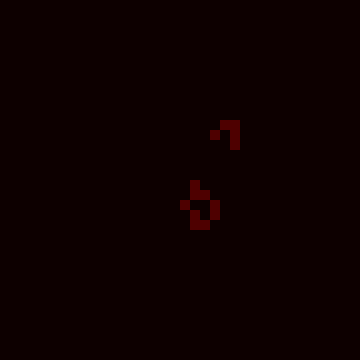
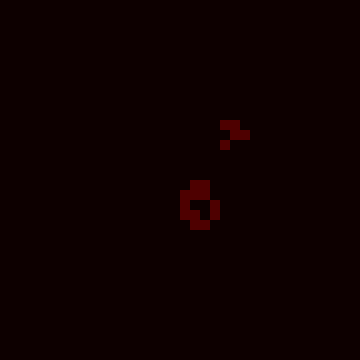
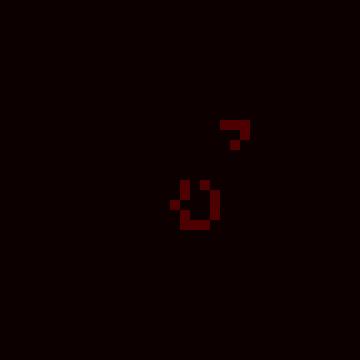
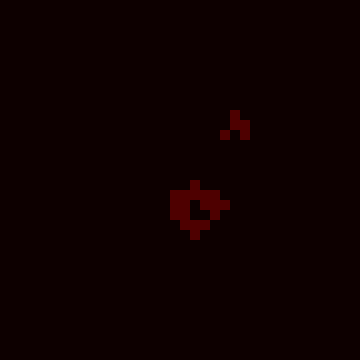
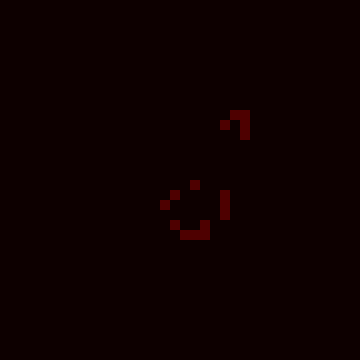
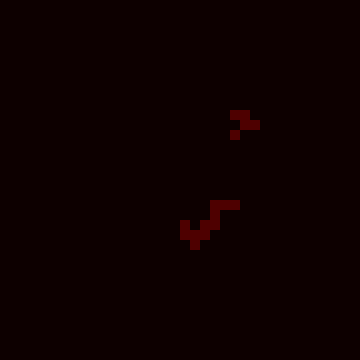
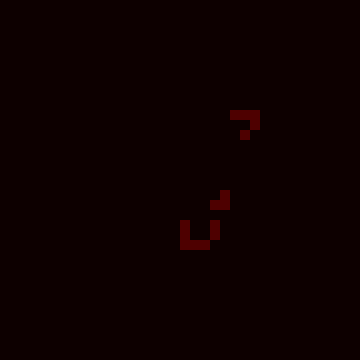
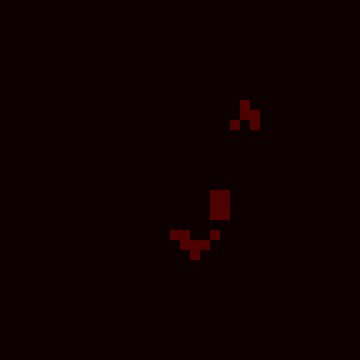
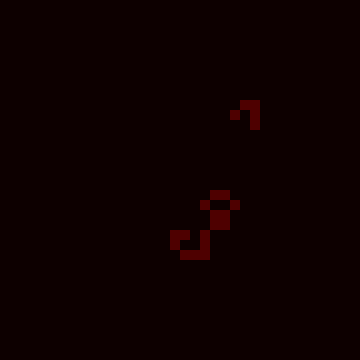
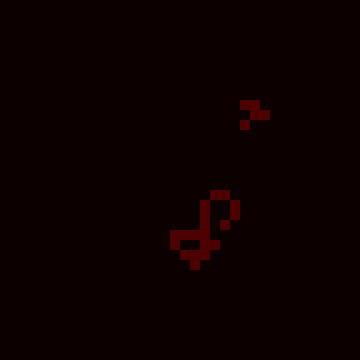
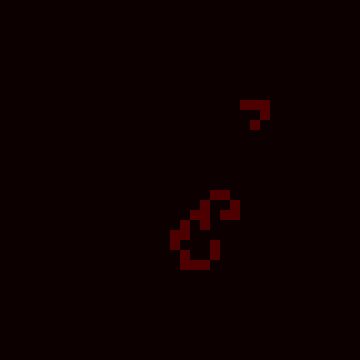
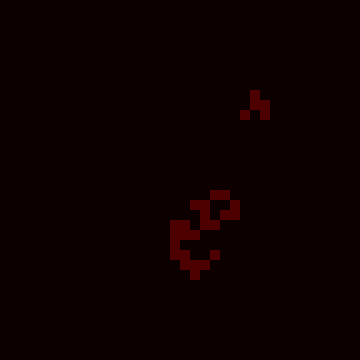
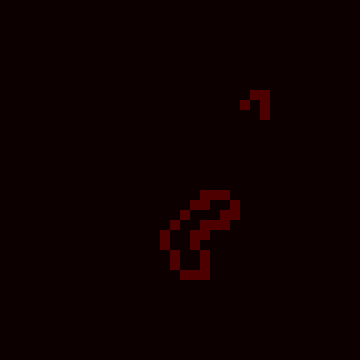
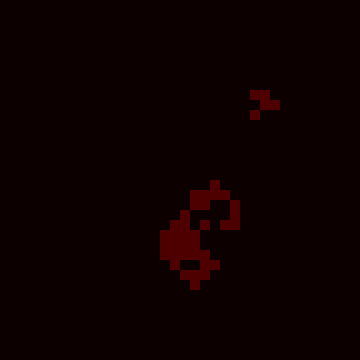
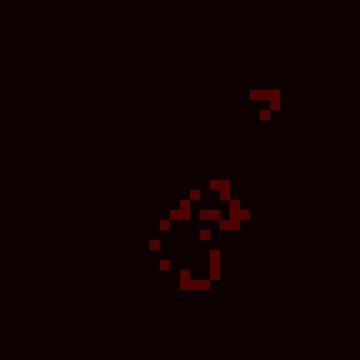
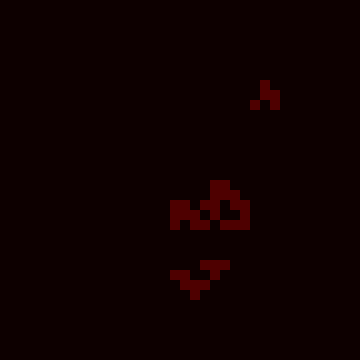
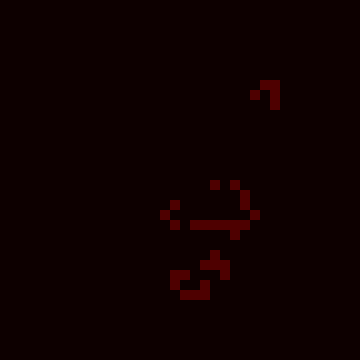
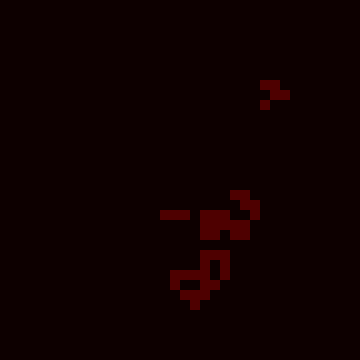
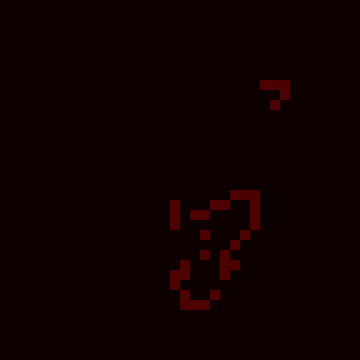
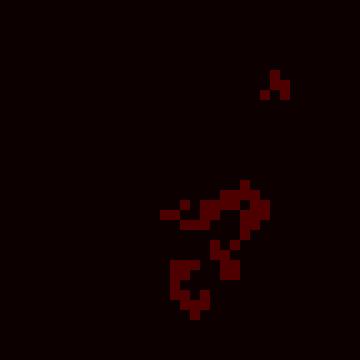
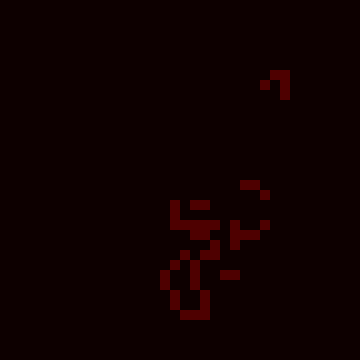
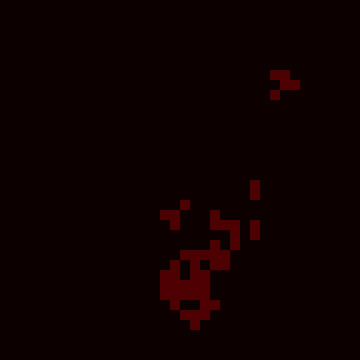
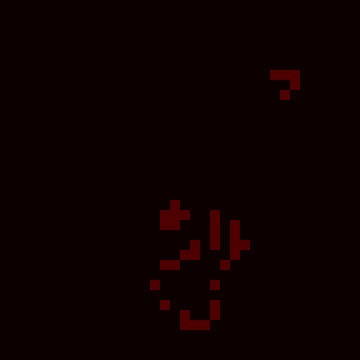
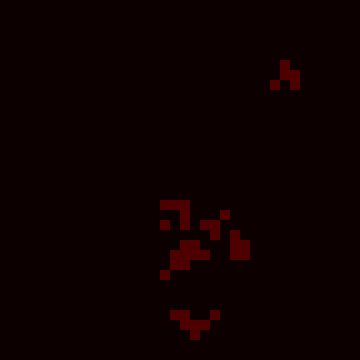
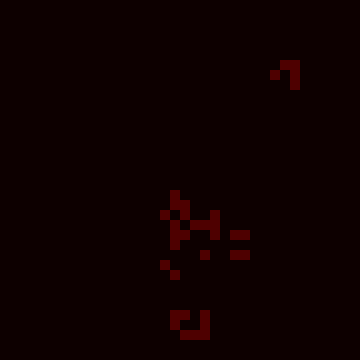
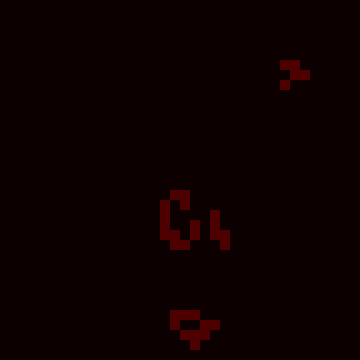
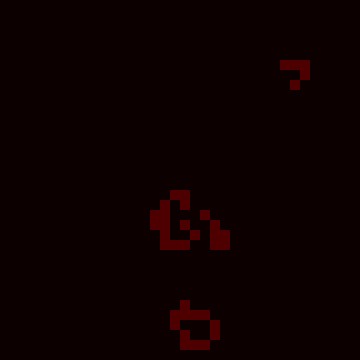
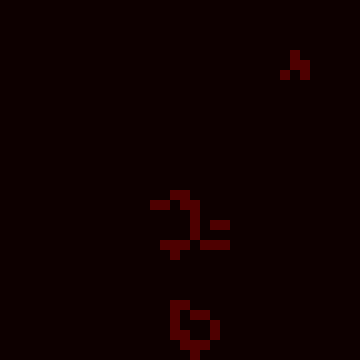
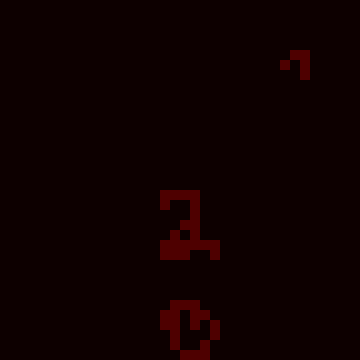
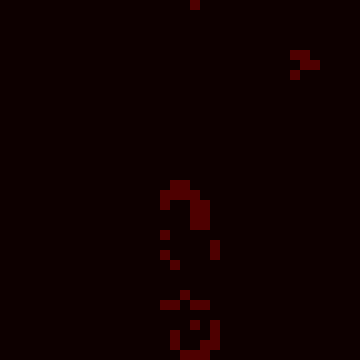
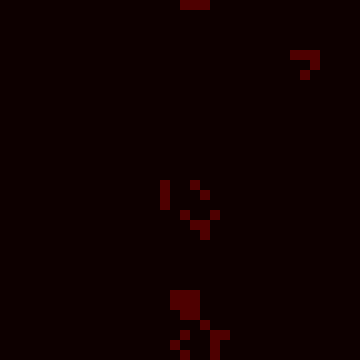
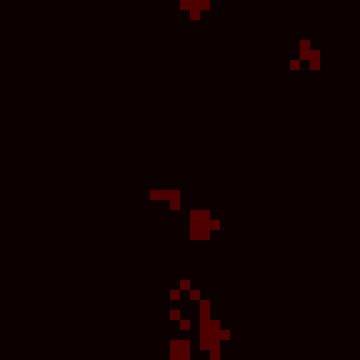
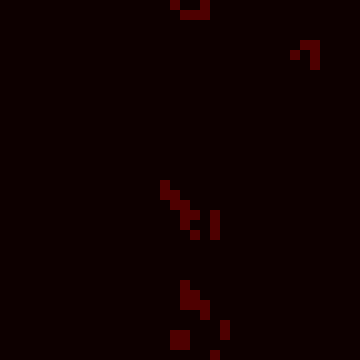
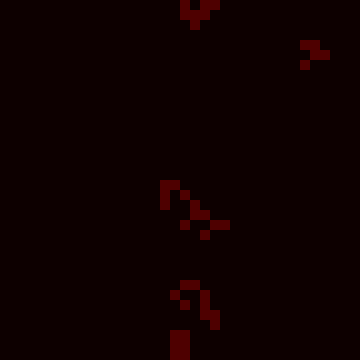
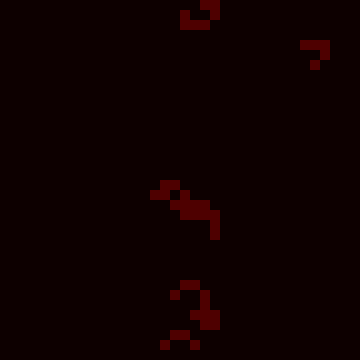
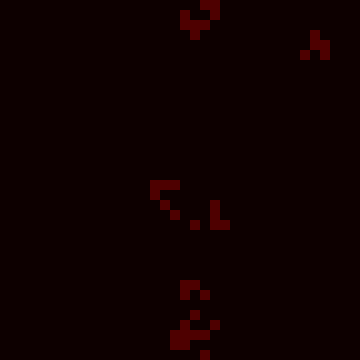
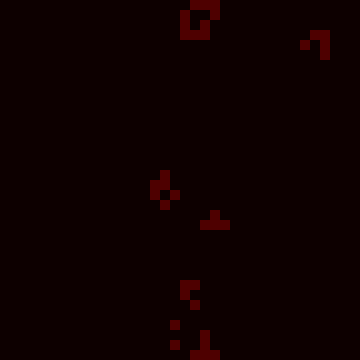
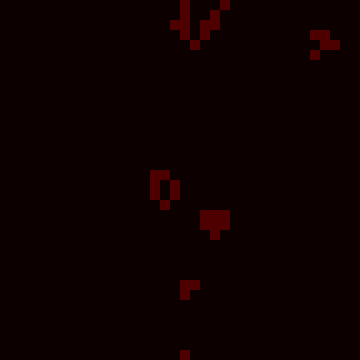
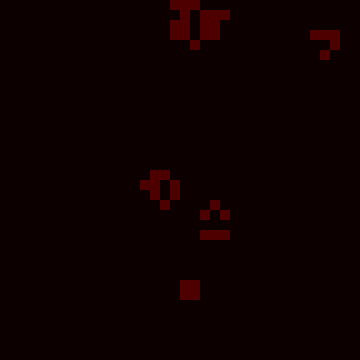
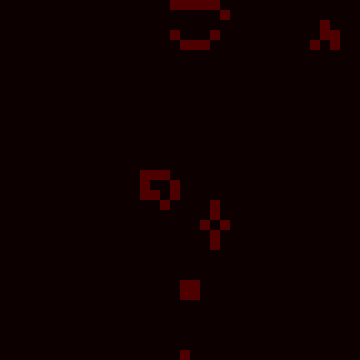
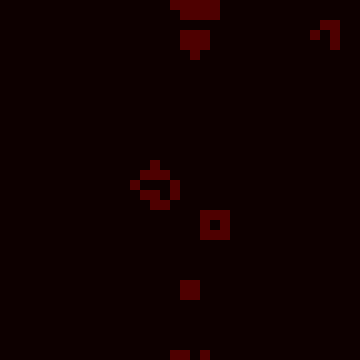
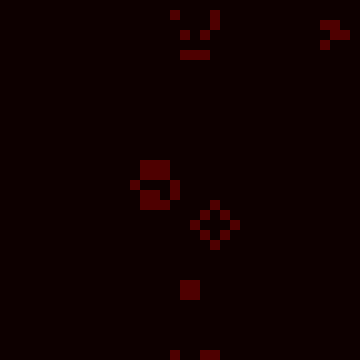
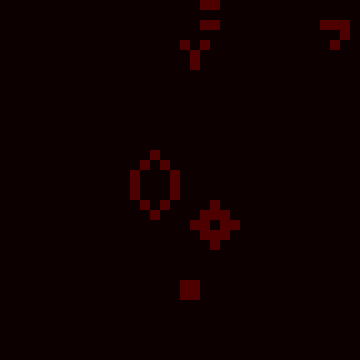
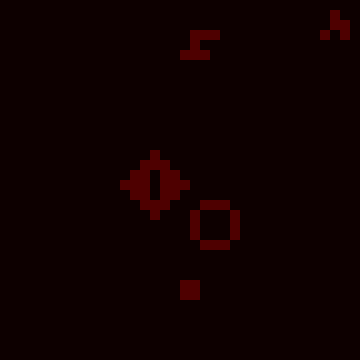
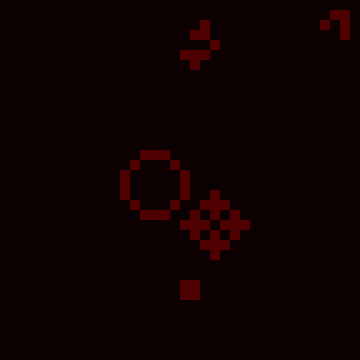
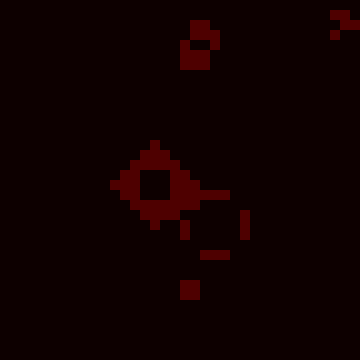
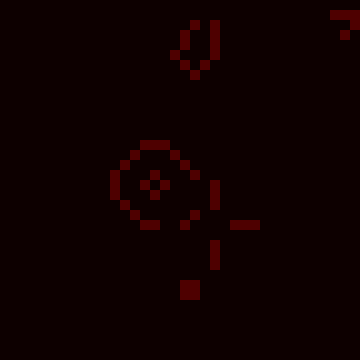
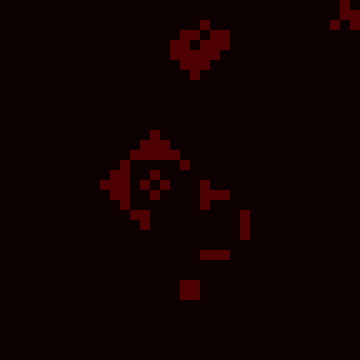
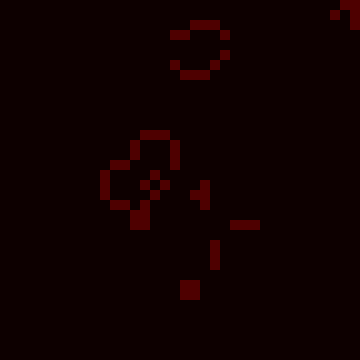
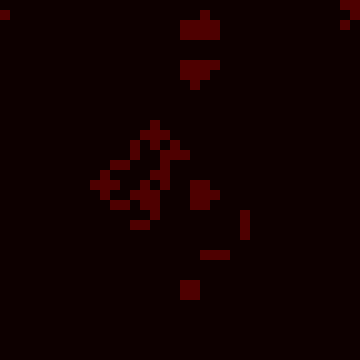
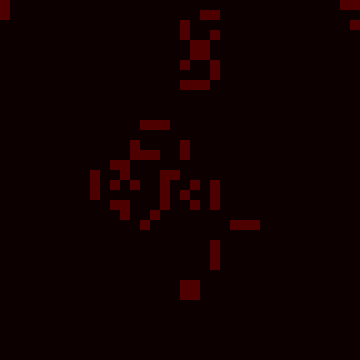
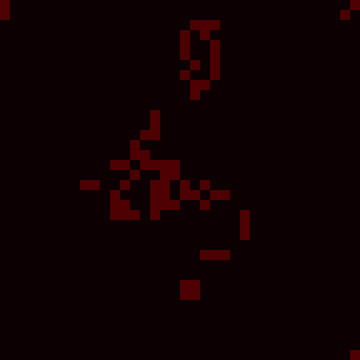
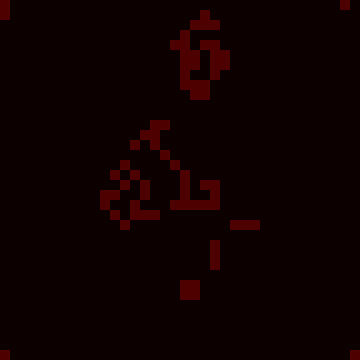
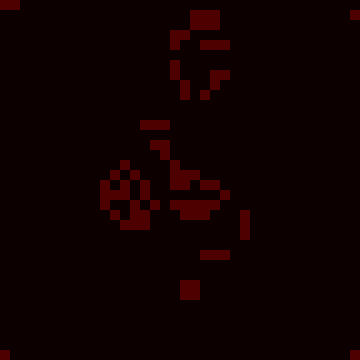
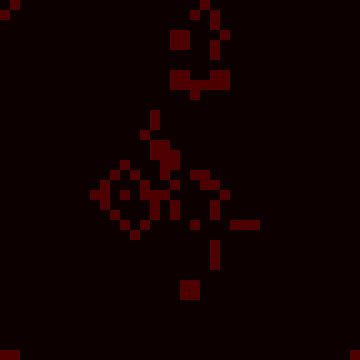
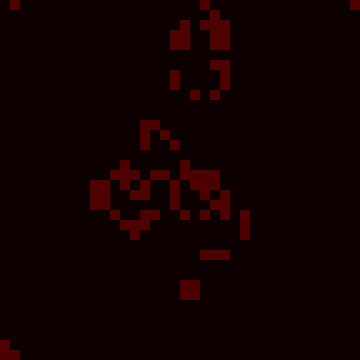
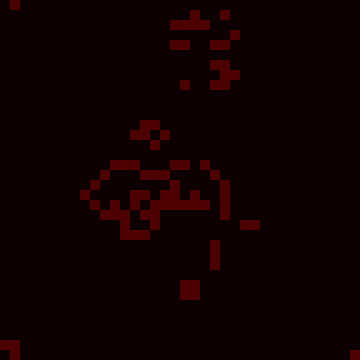
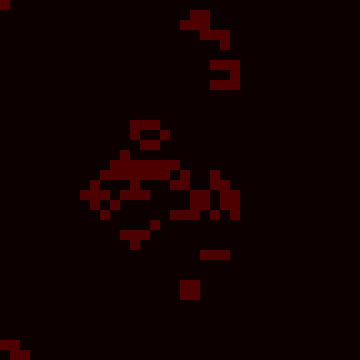
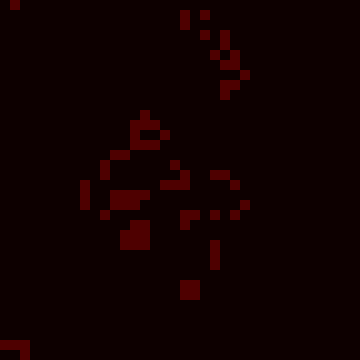
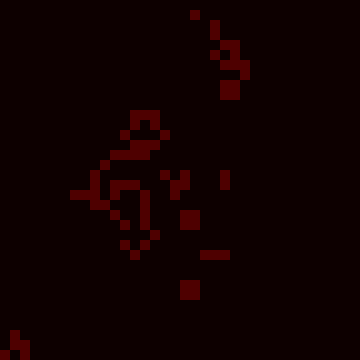
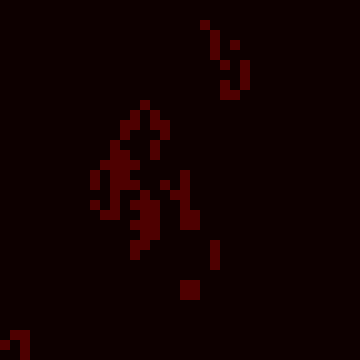
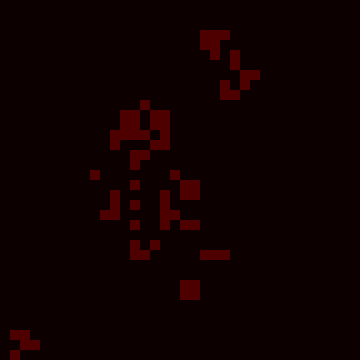
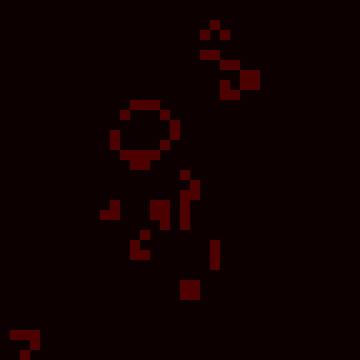
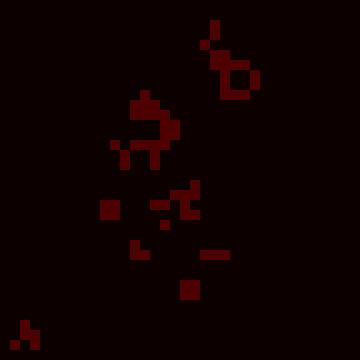
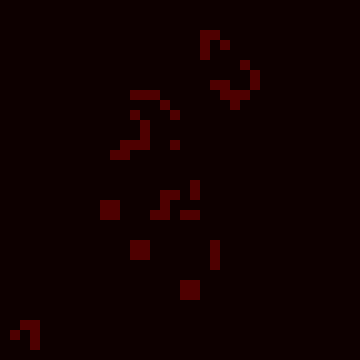
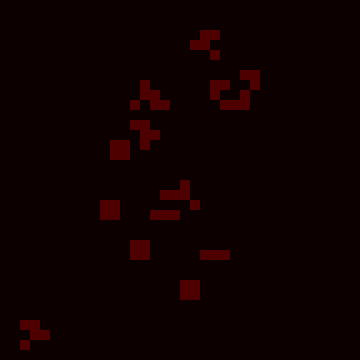
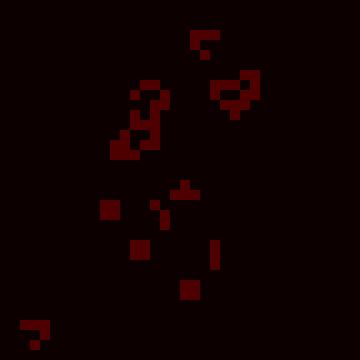
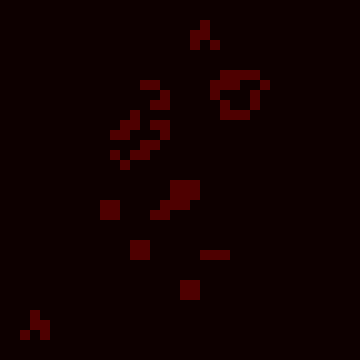
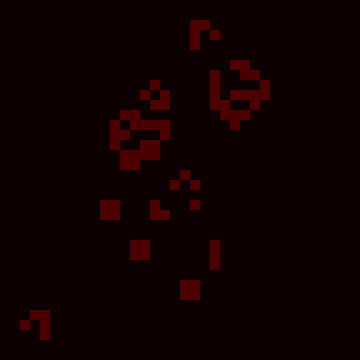
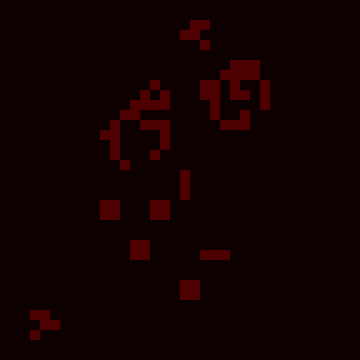
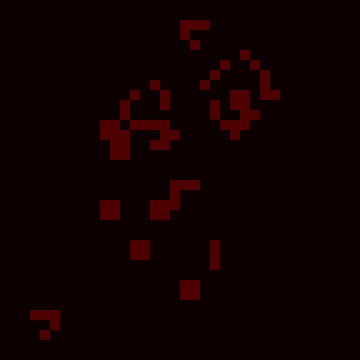
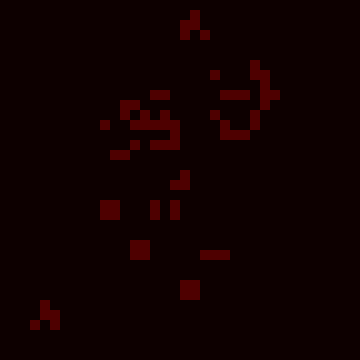
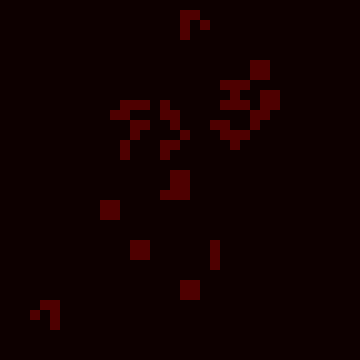
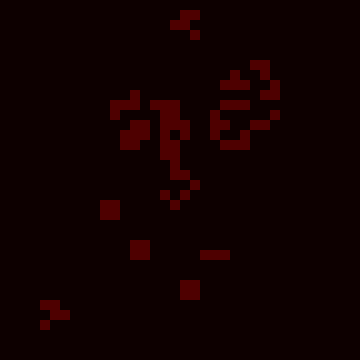
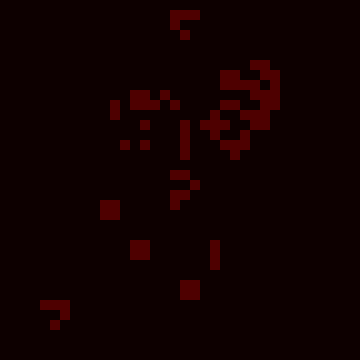
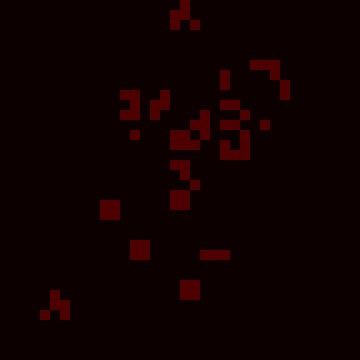
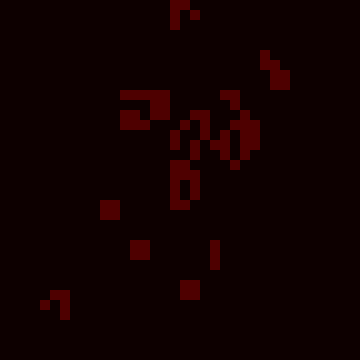
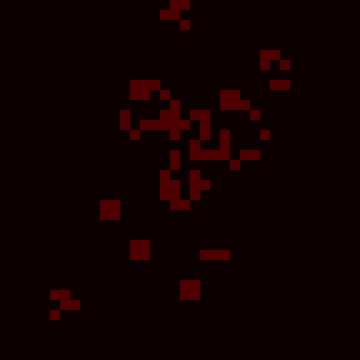

In [6]:
iteration_n = 10
frame_n = 100
xd = 4
yd = 4
sample_n = 100
border = 9

gen_noise = random.choice([0,1], [sample_n, xd*yd])
gen_weights = 2 * random.random((xd*yd, xd*yd)) - 1
des_weights = 2 * random.random((xd*yd, 1)) - 1
    
for k in range(iteration_n):
    
    print(k)
    
    # Generate Part 1 #########################################################
    
    generated = np.round(sig_func(gen_noise, gen_weights))
    
    #print("Generated")
    #print(generated.shape)

    # Evaluate ################################################################

    evaluated = []

    for i in range(sample_n):

        b = add_border(generated[i].reshape([xd, yd]), border)


        for j in range(frame_n-1):

            c = life_step(b.reshape([j+1,xd*border, yd*border])[j,:]).flatten()
            b = np.append(b,c)

        b = b.reshape(frame_n, xd*border, yd*border)

        dw_score = abs((durbin_watson(np.sum(b.reshape([frame_n,
                                                        xd*border*yd*border]),
                                             axis=1).tolist())-2)/2)
        cm_score = np.var(ndimage.center_of_mass(b))
        score = dw_score*np.log(cm_score)
        evaluated = np.append(evaluated,score)
        
    evaluated = evaluated.reshape([sample_n,1])
    
    print("Evaluated")
    print(np.max(evaluated))
    print(np.min(evaluated))

    #Descriminate #############################################################
    
    descriminated = sig_func(generated, des_weights)
    
    print("Descriminated")
    print(np.max(descriminated))
    print(np.min(descriminated))
    
    # Generate Part 2 #########################################################
    
    des_weights += np.dot(generated.T,
                          (evaluated - descriminated) *
                          descriminated *
                          (1 - descriminated))

    result = np.argsort(sig_func(generated, des_weights)).flatten()
    top_n = result[::-1][:int(sample_n/2)]
    bottom_n = result[:int(sample_n/2)]

    placeholder= np.dot(random.choice([0,1], [int(sample_n/2), xd*yd]).T,
                          (generated[top_n] - generated[bottom_n]) *
                          generated[bottom_n] *
                          (1 - generated[bottom_n]))
    
    gen_weights += placeholder
    
    print("placeholder")
    print(placeholder)
    
    print("Gen Weigths")
    print(np.sum(gen_weights))

    
# Get Best and Display ########################################################

top_inds = np.argsort(evaluated.flatten())[::-1]
top_ind = top_inds[0]
top_scores = evaluated[top_inds]
top_score = evaluated[top_ind]
top_im = generated[top_ind].reshape([xd,yd])

clear_output(wait=True)
print(top_inds)
print(top_scores.flatten())
print(top_im)
life_animation(add_border(top_im, border),
               dpi=15,
               frames=frame_n,
               interval=50,
               mode='once')

[[0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 1. 1.]
 [1. 0. 0. 0.]]



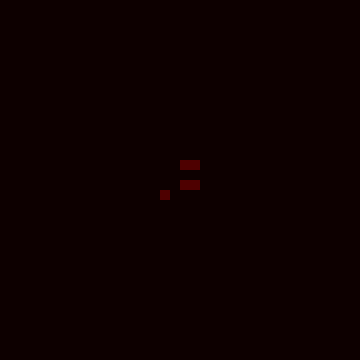
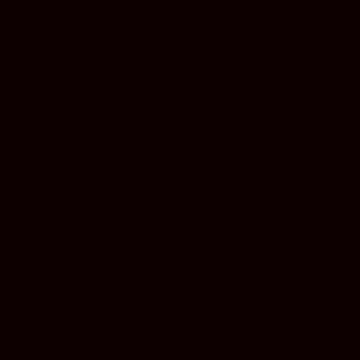
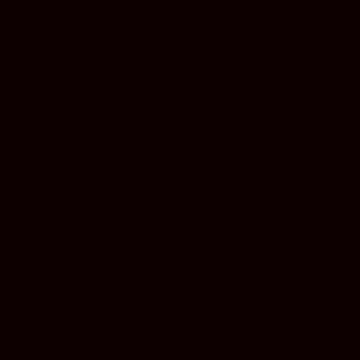
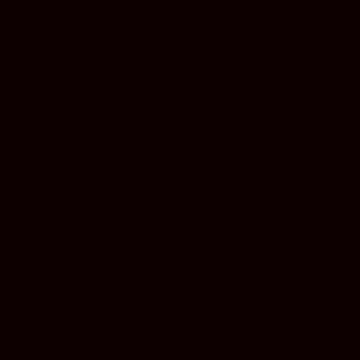
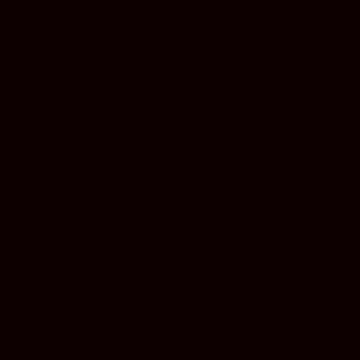
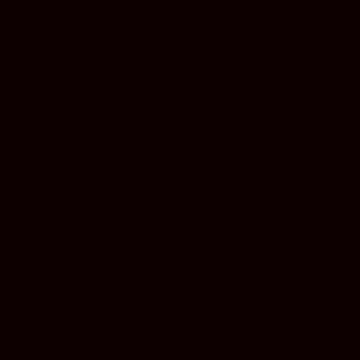
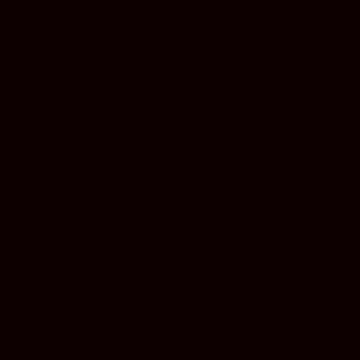
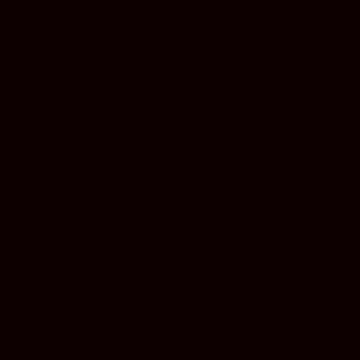
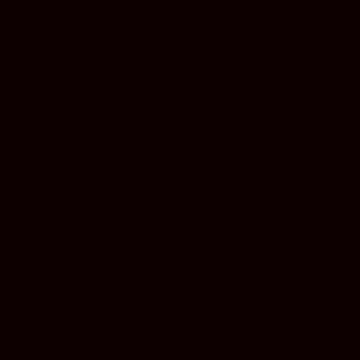
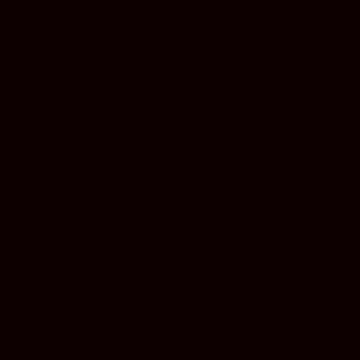
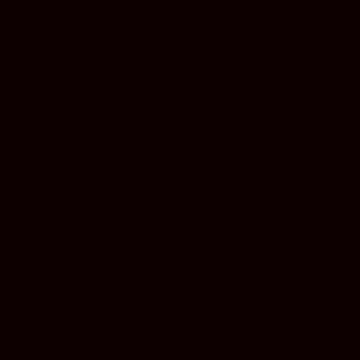
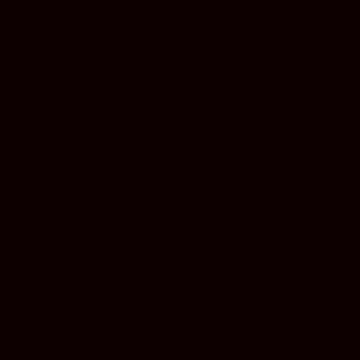
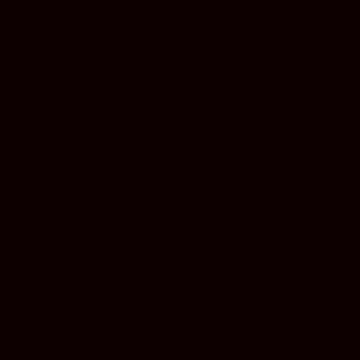
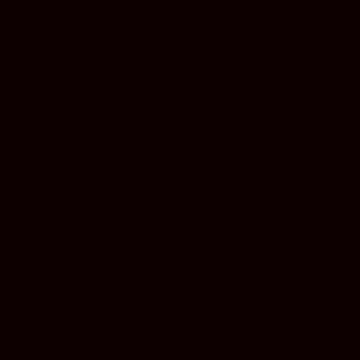
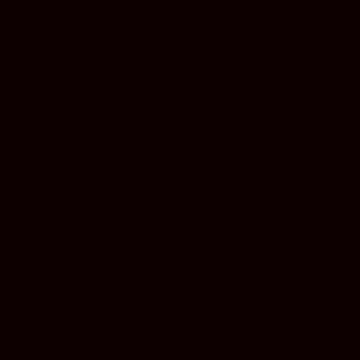
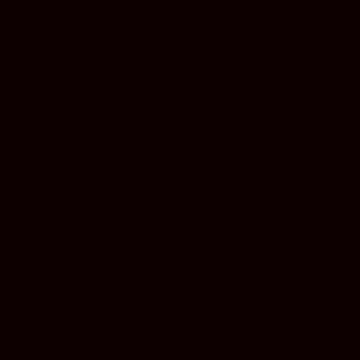
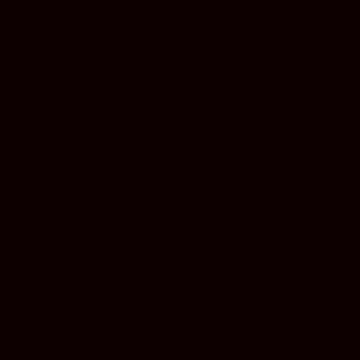
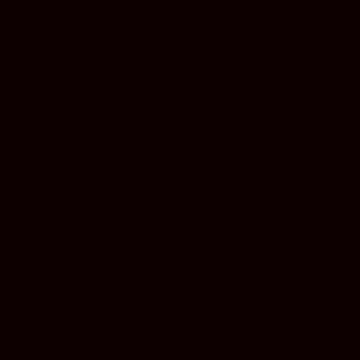
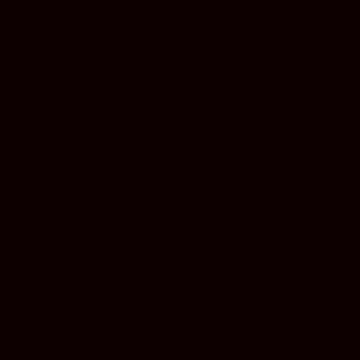
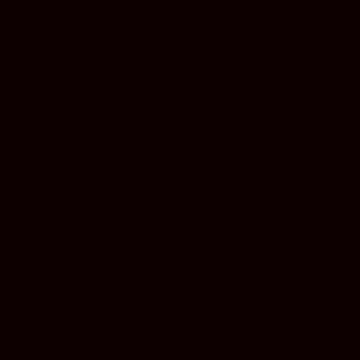
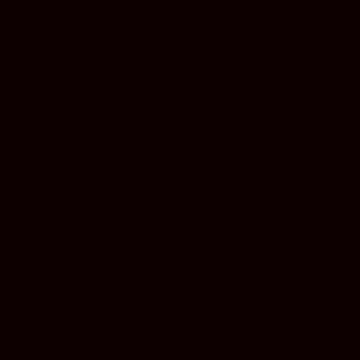
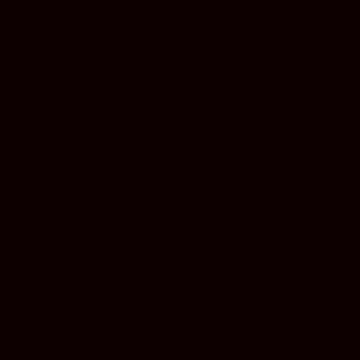
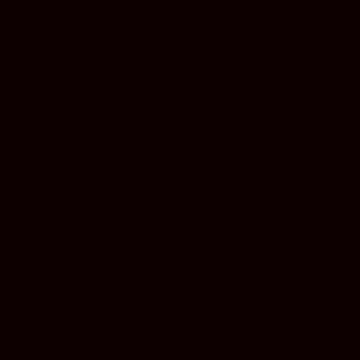
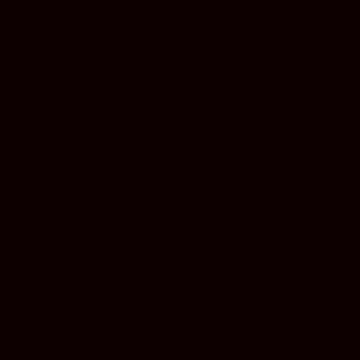
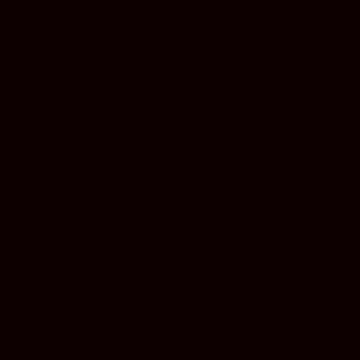
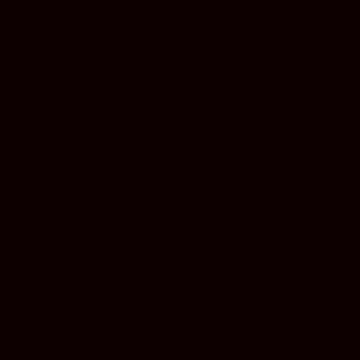
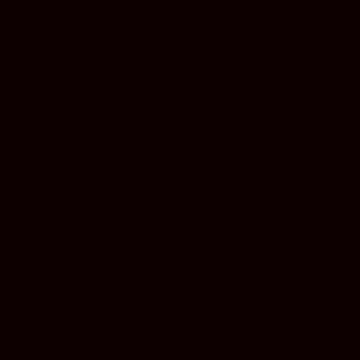
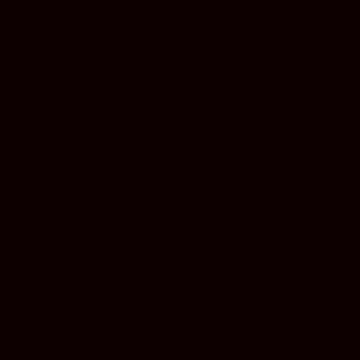
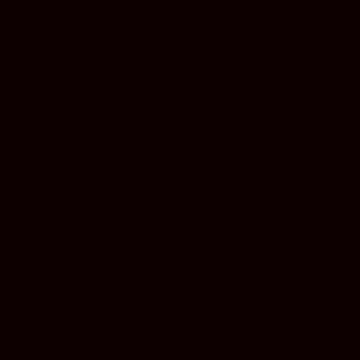
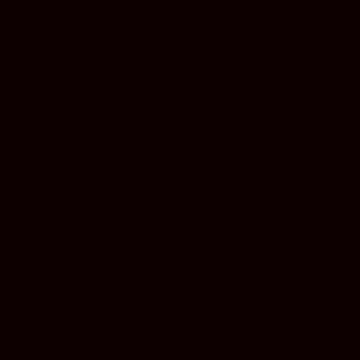
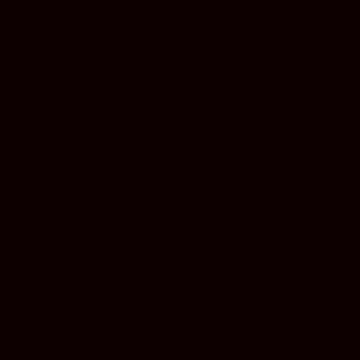
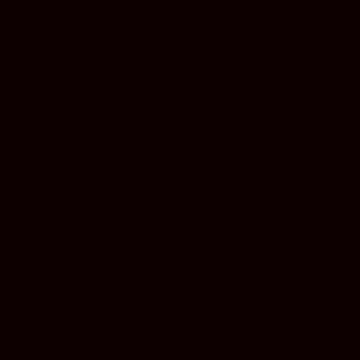
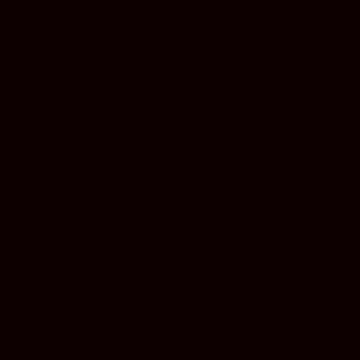
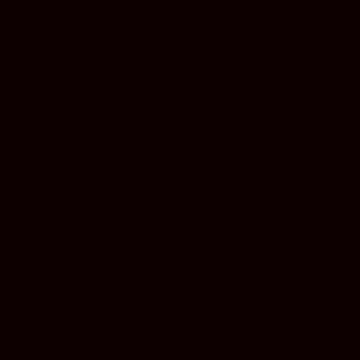
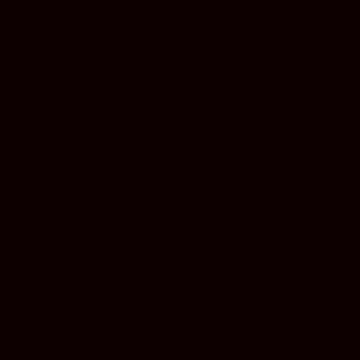
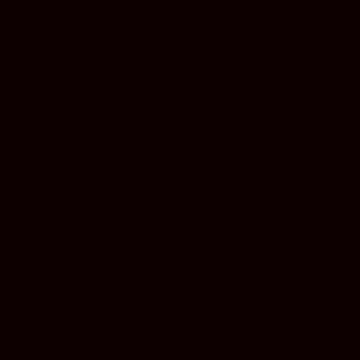
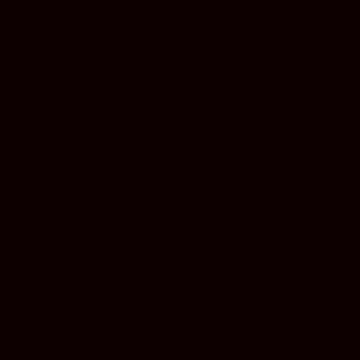
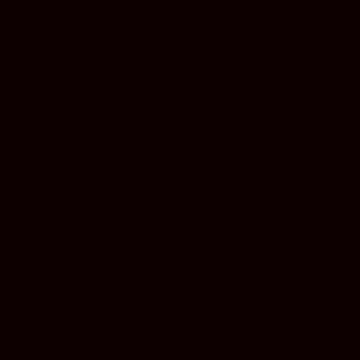
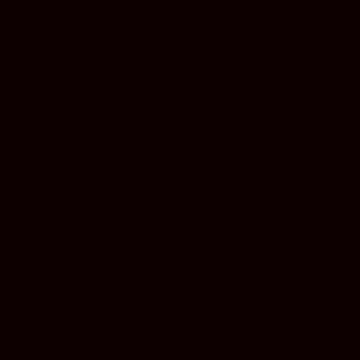
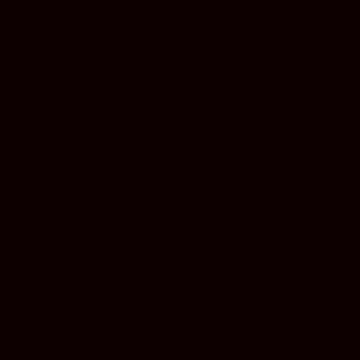
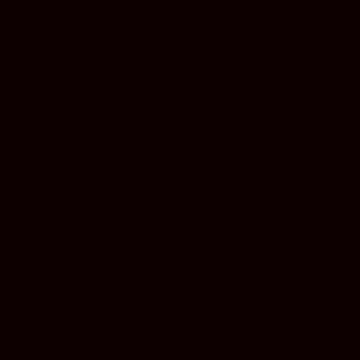
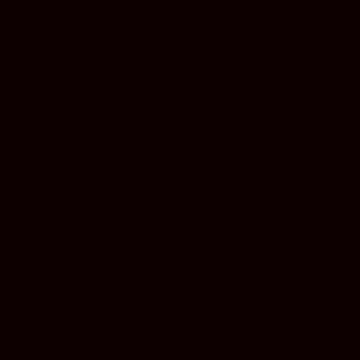
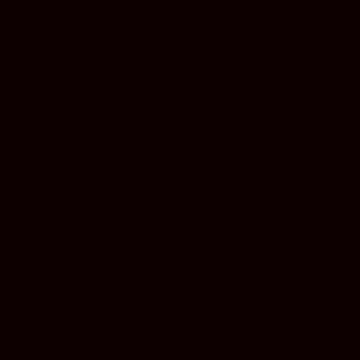
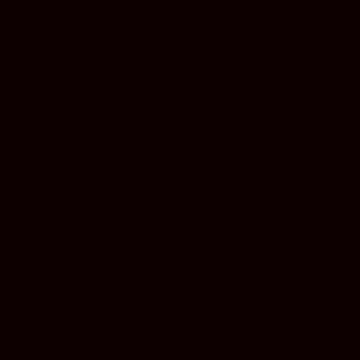
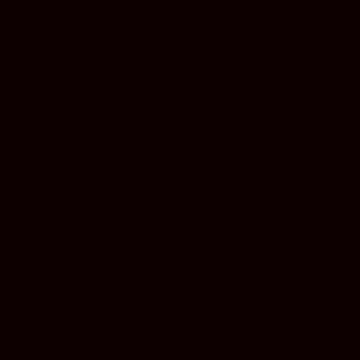
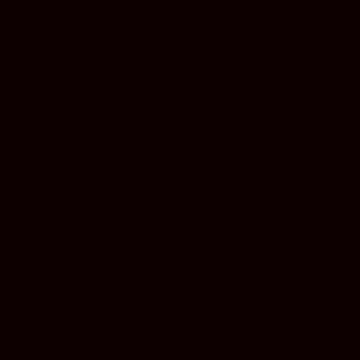
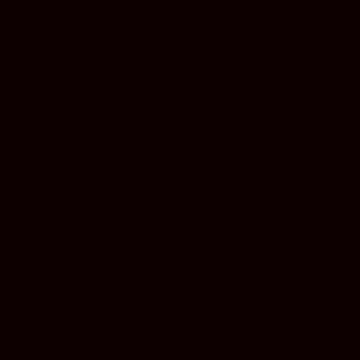
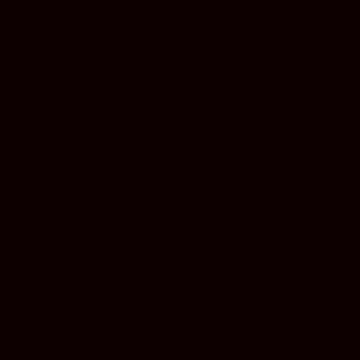
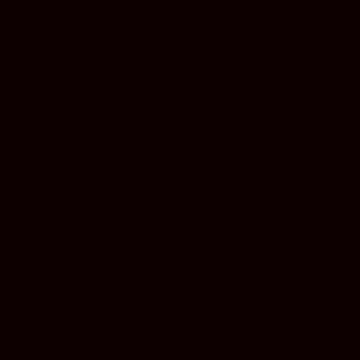
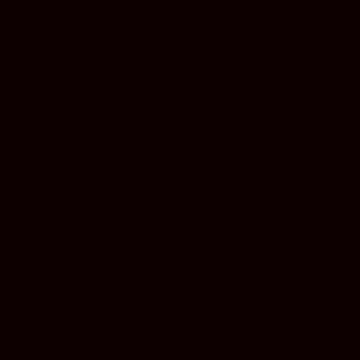
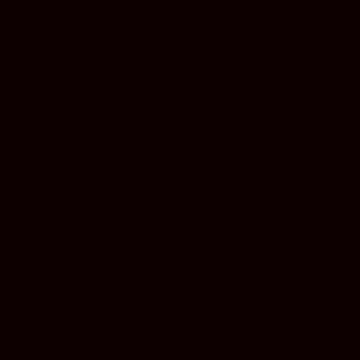
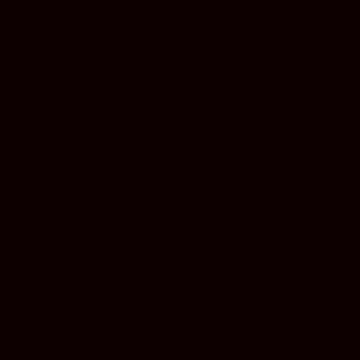
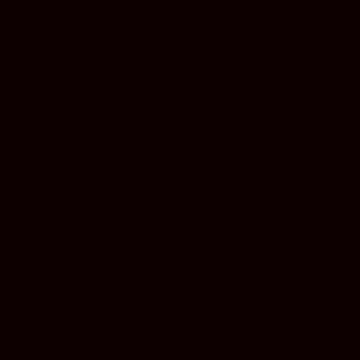
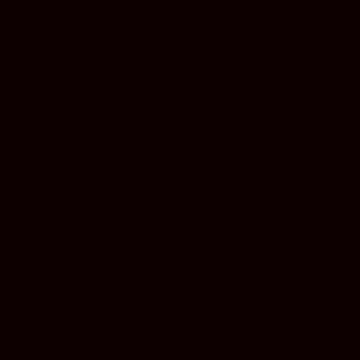
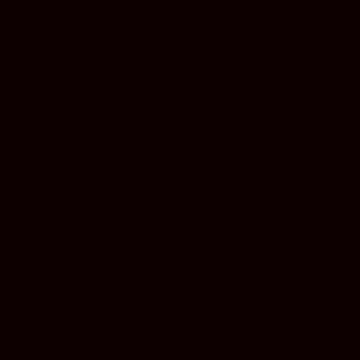
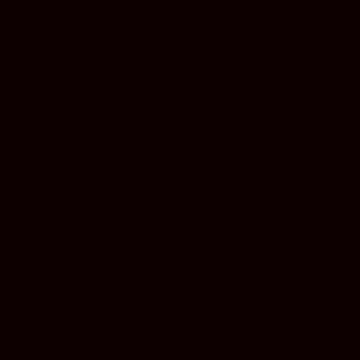
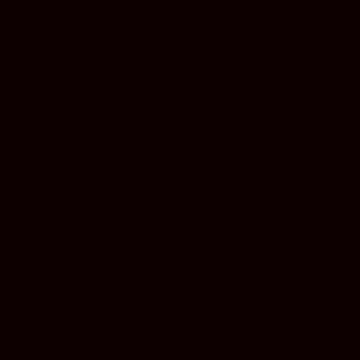
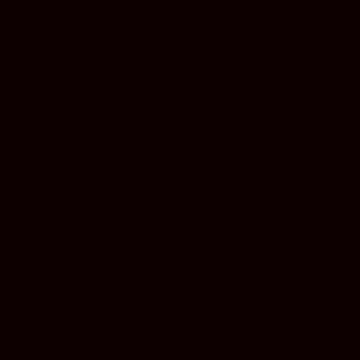
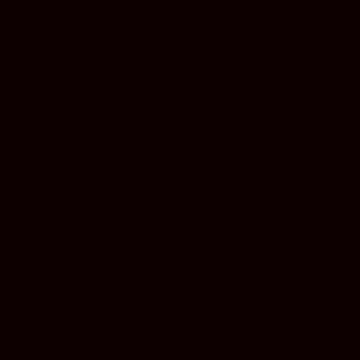
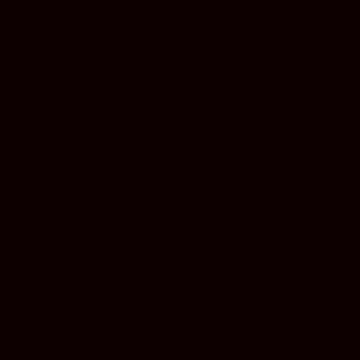
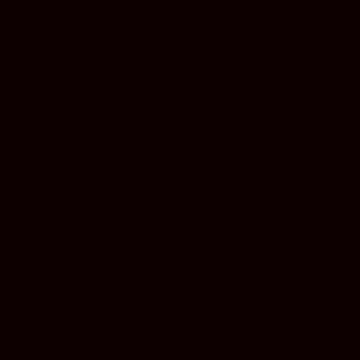
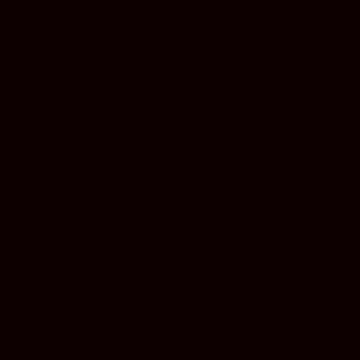
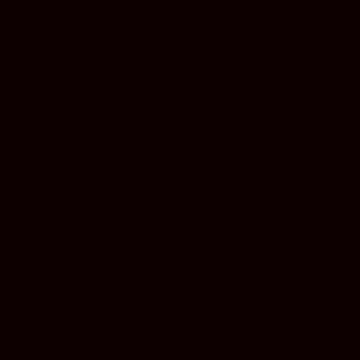
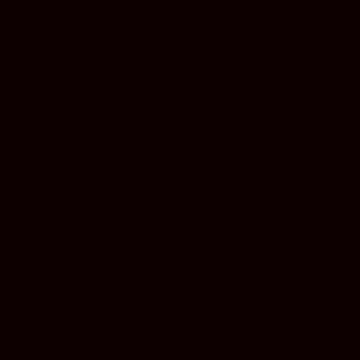
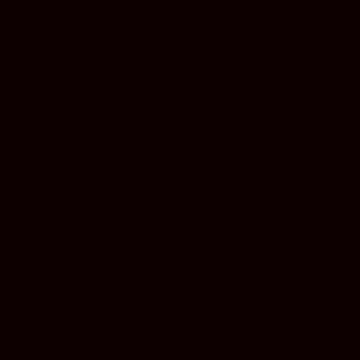
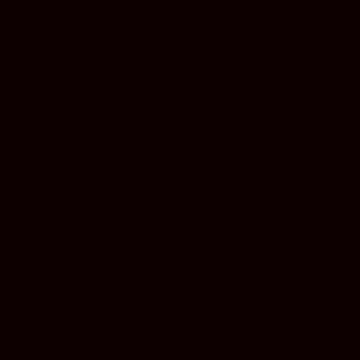
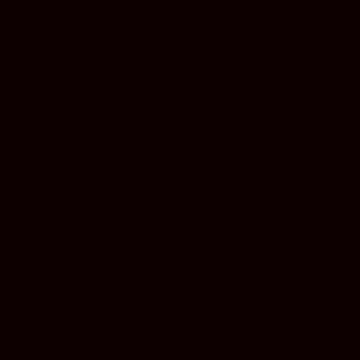
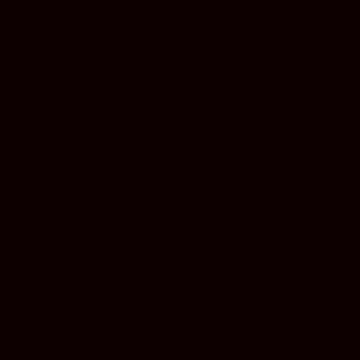
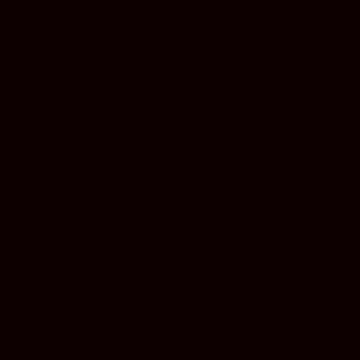
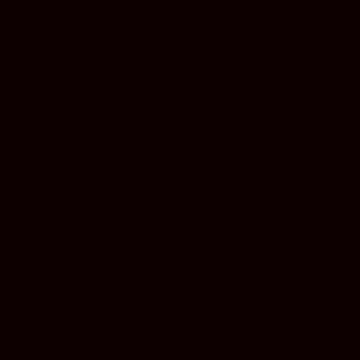
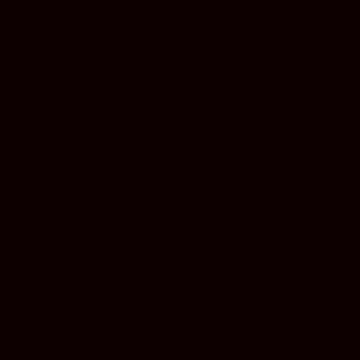
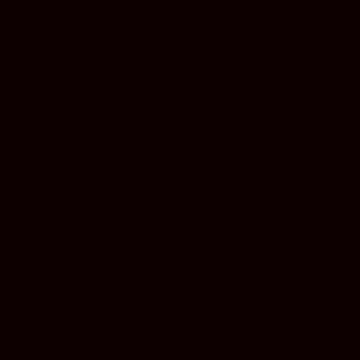
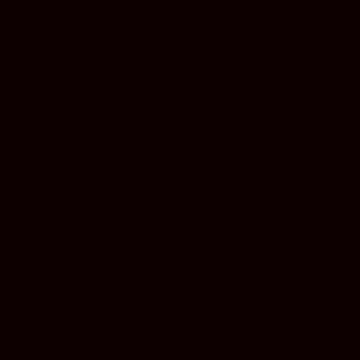
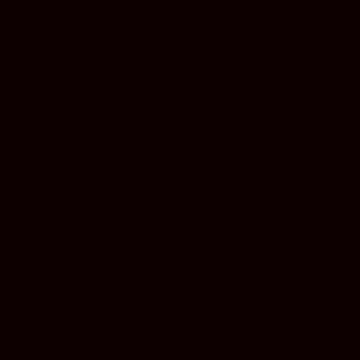
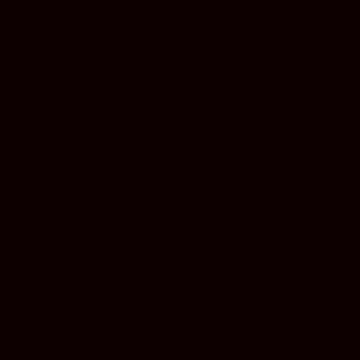
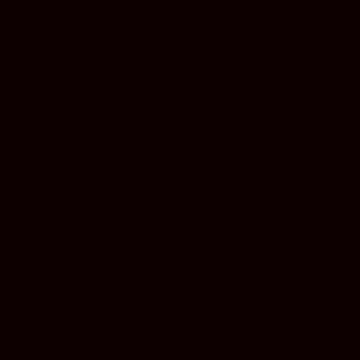
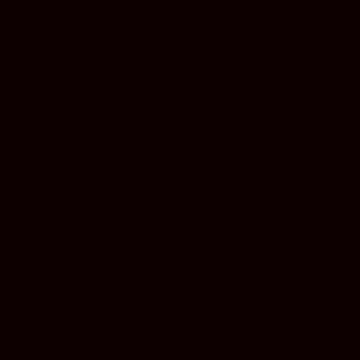
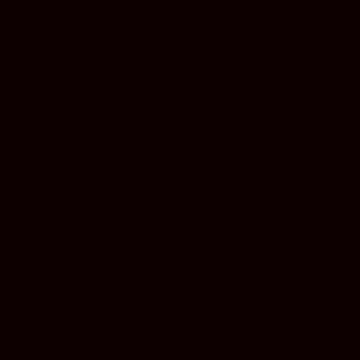
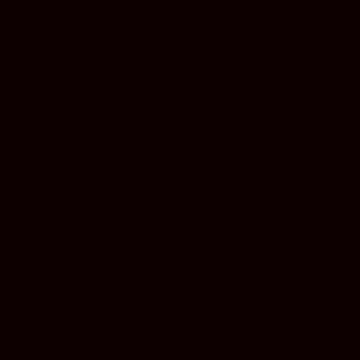
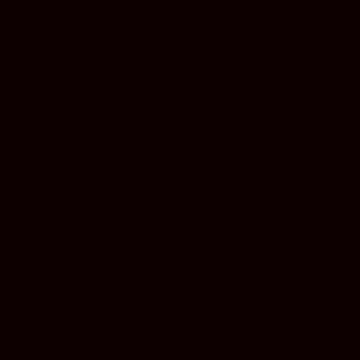
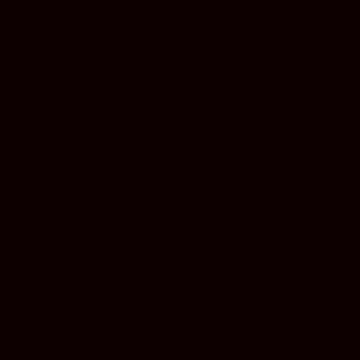
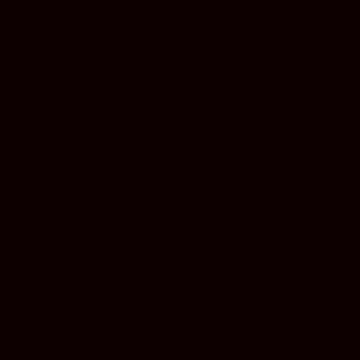
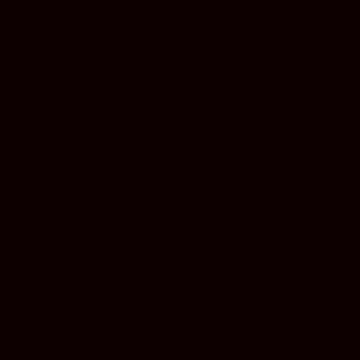
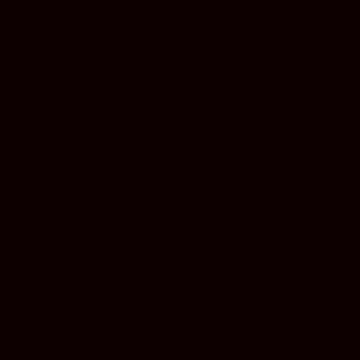
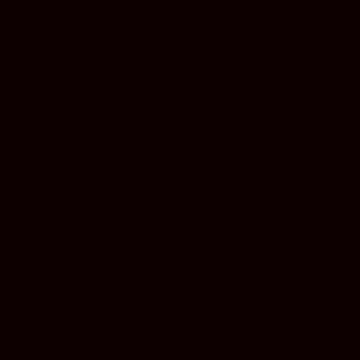
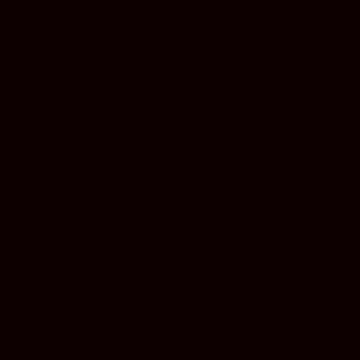
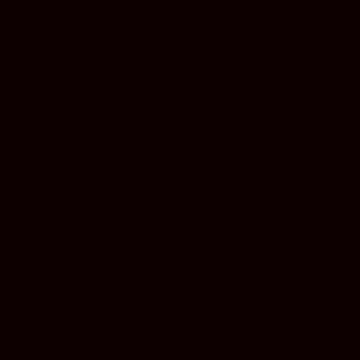
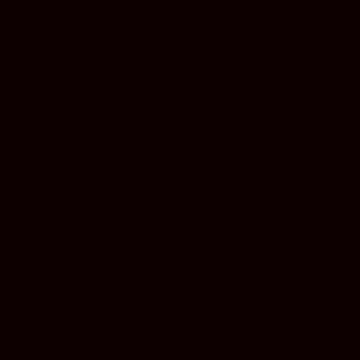
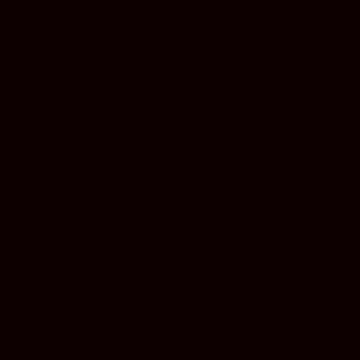
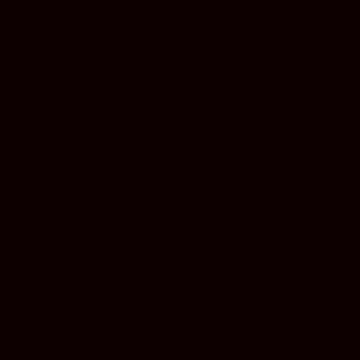
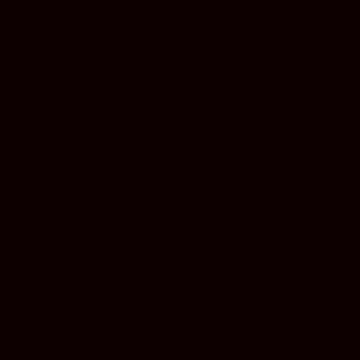
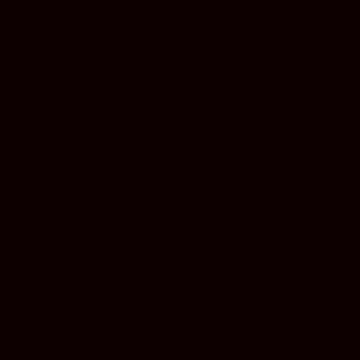
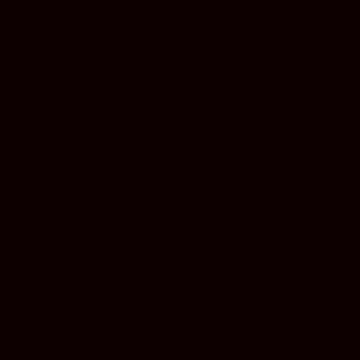
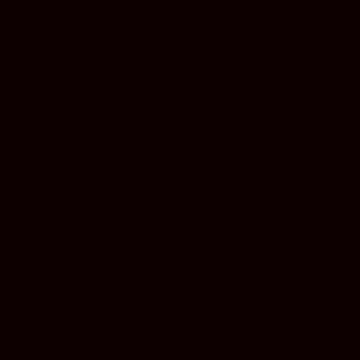
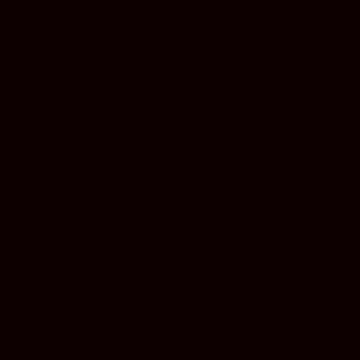
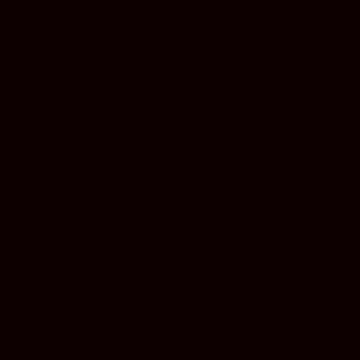
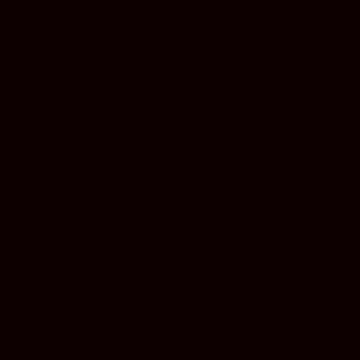
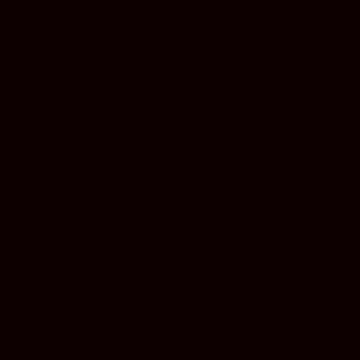
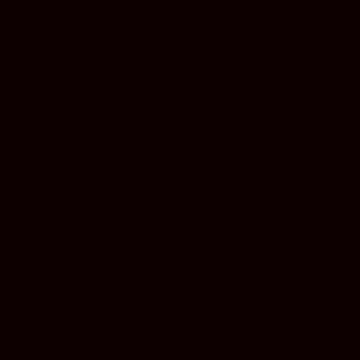
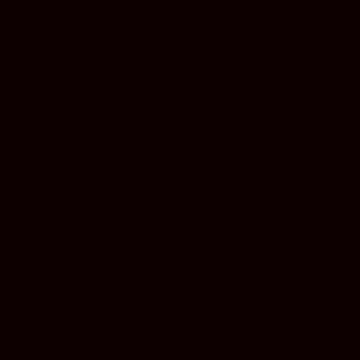

In [7]:
bottom_ind = top_inds[-1]
bottom_im = generated[bottom_ind].reshape([xd,yd])
print(bottom_im)
life_animation(add_border(generated[bottom_ind].reshape([xd,yd]), border),
               dpi=15,
               frames=frame_n,
               interval=50,
               mode='once')